# Notebook 5.1 - Time Series Forecasting

Management Science - Predicting Bean Counter’s Future

# Introduction

Welcome back, CEO! After successfully using Monte Carlo simulation to
plan Bean Counter’s expansion, you now face a new challenge:
**predicting future demand** for your seasonal products.

**The Seasonal Challenge:** Bean Counter has expanded beyond regular
coffee into seasonal drinks:

-   **Iced Coffee** (summer favorite)
-   **Pumpkin Spice Latte** (fall special)
-   **Peppermint Hot Chocolate** (winter warmer)

You have 2 years of daily sales data. The board wants accurate forecasts
for next month to optimize inventory. Overstock means waste (drinks
expire), understock means lost sales and unhappy customers!

> **How to Use This Tutorial**
>
> Cells marked with “YOUR CODE BELOW” expect you to write code. Test
> your solutions with the provided assertions. Work through the sections
> in order - each builds on previous concepts!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(2025)
print("Libraries loaded! Time to predict Bean Counter's future.")

Libraries loaded! Time to predict Bean Counter's future.

# Section 1 - Working with Time Series Data

Before we can forecast, we need to understand how to work with dates and
time-based data in pandas.

## Understanding Date Conversion

In [2]:
# Example: Converting strings to dates
date_strings = ['2024-01-15', '2024-02-20', '2024-03-10']
dates = pd.to_datetime(date_strings)
print("Original strings:", date_strings)
print("\nConverted to datetime:", dates)
print("\nExtract components:")
print(f"  Months: {dates.month.tolist()}")
print(f"  Day of week: {dates.day_name().tolist()}")

Original strings: ['2024-01-15', '2024-02-20', '2024-03-10']

Converted to datetime: DatetimeIndex(['2024-01-15', '2024-02-20', '2024-03-10'], dtype='datetime64[ns]', freq=None)

Extract components:
  Months: [1, 2, 3]
  Day of week: ['Monday', 'Tuesday', 'Sunday']

> **Tip**
>
> Use `.dt` accessor to extract date parts:
>
> -   `.dt.month` - Month (1-12)
> -   `.dt.day_of_week` - Day (0=Monday, 6=Sunday)
> -   `.dt.quarter` - Quarter (1-4)
> -   `.dt.is_month_end` - Boolean for month end

> **Tip**
>
> To access specific elements, e.g. the third month of a year from a
> DataFrame, you can use `df['date'].dt.month.iloc[2]`. Step by step
> this happens:
>
> 1.  You access the `date` column using `df['date']`.
> 2.  You use the `.dt` accessor to extract the month part.
> 3.  You use `.iloc[2]` to select the third element.

## Exercise 1.1 - Load and Prepare Sales Data

Create a DataFrame with Bean Counter’s sales data and convert the date
column properly.

In [3]:
# DON'T CHANGE ANYTHING BELOW!
# Creates sample sales data for Bean Counter (3 years for enough seasonal cycles)
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Generate sales with trend and seasonality
base_sales = 100
trend = np.linspace(0, 60, len(dates))  # Growing trend over 3 years
# Summer peaks for iced coffee! (high in June-Aug, low in Dec-Feb)
seasonal = 45 * np.sin(2 * np.pi * (np.arange(len(dates)) - 80) / 365.25)  # Yearly pattern, peaks in summer
weekly = 15 * np.sin(2 * np.pi * np.arange(len(dates)) / 7)  # Weekend peaks
noise = np.random.normal(0, 20, len(dates))  # Controlled noise
sales = base_sales + trend + seasonal + weekly + noise
# DON'T CHANGE ANYTHING ABOVE!

> **Creating DataFrames and Working with Dates**
>
> ``` python
> # Create DataFrame from dictionary
> df = pd.DataFrame({'col1': values1, 'col2': values2})
>
> # Access datetime attributes with .dt
> df['date'].dt.month   # Extract month (1-12)
> df['date'].dt.year    # Extract year
> df['date'].dt.day     # Extract day
>
> # Get first/last element
> df['column'].iloc[0]   # First element
> df['column'].iloc[-1]  # Last element
> ```

In [4]:
# YOUR CODE BELOW

# Create DataFrame with date and sales columns
df =   # Create the DataFrame with 'date' and 'sales' columns

# Extract month from the date column
# Hint: Use .dt.month to get month, then .iloc[0] or .iloc[-1]
first_month =   # Get the month of the first date
last_month =    # Get the month of the last date

In [6]:
# Don't modify below - these test your solution
assert 'date' in df.columns, "DataFrame should have a 'date' column"
assert 'sales' in df.columns, "DataFrame should have a 'sales' column"
assert first_month == 1, f"First month should be January (1), got {first_month}"
assert last_month == 12, f"Last month should be December (12), got {last_month}"
print("Great! Sales data loaded and dates properly formatted!")

# Quick visualization of your loaded data
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['sales'], linewidth=1, alpha=0.7, color='#537E8F')
plt.xlabel('Date')
plt.ylabel('Sales (drinks)')
plt.title('Bean Counter Sales - Your Loaded Data')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercise 1.2 - Analyze Sales Patterns

Calculate key statistics about Bean Counter’s sales to understand the
data.

> **Tip**
>
> You can use methods like `mean()`, `max()`, and `min()` to calculate
> basic statistics with DataFrames. You just need to call these methods
> on the ‘sales’ column of the DataFrame.

In [7]:
# YOUR CODE BELOW
# Calculate basic statistics
mean_sales =   # Average daily sales
max_sales =    # Highest sales day
min_sales =    # Lowest sales day

In [9]:
# Don't modify below
assert 115 < mean_sales < 135, f"Mean sales should be ~125, got {mean_sales:.1f}"
assert max_sales > 180, f"Max sales should be >180, got {max_sales:.1f}"
assert min_sales < 70, f"Min sales should be <70, got {min_sales:.1f}"
print(f"Excellent! Analysis complete!")
print(f"Daily average: {mean_sales:.0f} drinks")

# Section 2 - Moving Averages: Smoothing the Noise

Daily sales are noisy. Moving averages help us see the underlying
patterns by averaging nearby data points.

## Understanding Moving Averages

**The Concept:** A moving average smooths data by calculating the
average of a “window” of recent values. As we move forward in time, the
window slides along the data.

**Example:** For a 3-day moving average:

-   Day 3 average: (Day1 + Day2 + Day3) / 3
-   Day 4 average: (Day2 + Day3 + Day4) / 3
-   Day 5 average: (Day3 + Day4 + Day5) / 3

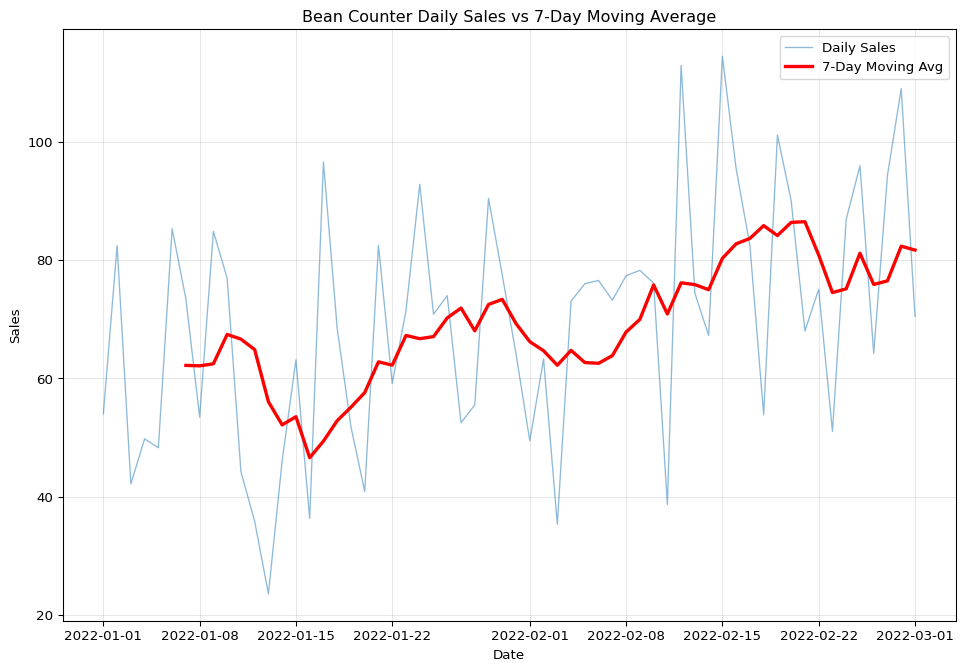

In [10]:
# Example: 7-day moving average
df['MA7'] = df['sales'].rolling(window=7).mean()

# Plot comparison (first 60 days)
plt.figure(figsize=(12, 8))
plt.plot(df['date'][:60], df['sales'][:60], alpha=0.5, label='Daily Sales', linewidth=1)
plt.plot(df['date'][:60], df['MA7'][:60], linewidth=2.5, label='7-Day Moving Avg', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Bean Counter Daily Sales vs 7-Day Moving Average')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

> **NaN Values in Moving Averages**
>
> The first (window-1) values will be NaN because there aren’t enough
> previous values to calculate the average! For a 7-day MA, the first 6
> values are NaN. To find the number of NaN values in a moving average,
> you can use the `isna()` method to check for NaN values and then count
> them using the `sum()` method, e.g., `df['MA7'].isna().sum()`.

## Exercise 2.1 - Create Multiple Moving Averages

Calculate different window sizes to see their smoothing effects.

> **Rolling Windows and NaN Values**
>
> ``` python
> # Create rolling window and calculate mean
> df['MA7'] = df['sales'].rolling(window=7).mean()
>
> # Count missing (NaN) values
> na_count = df['MA7'].isna().sum()
>
> # Why NaN? First 6 rows have no 7-day window yet!
> # Window of 7 → first 6 values are NaN
> ```

In [11]:
# YOUR CODE BELOW
# Calculate moving averages with different windows
df['MA3'] =   # 3-day moving average
df['MA14'] =  # 14-day (2 week) moving average
df['MA30'] =  # 30-day (monthly) moving average

# Count NaN values in each
# Hint: Use .isna().sum()
na_count_3 =   # Number of NaN values in MA3
na_count_14 =  # Number of NaN values in MA14
na_count_30 =  # Number of NaN values in MA30

In [13]:
# Don't modify below
assert na_count_3 == 2, f"MA3 should have 2 NaN values, got {na_count_3}"
assert na_count_14 == 13, f"MA14 should have 13 NaN values, got {na_count_14}"
assert na_count_30 == 29, f"MA30 should have 29 NaN values, got {na_count_30}"
assert df['MA30'].std() < df['MA3'].std(), "MA30 should be smoother (lower std) than MA3"
print("Perfect! Moving averages calculated correctly!")
print(f"  MA30 is {df['MA3'].std() / df['MA30'].std():.1f}x smoother than MA3")

# Visualize the smoothing effect
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['sales'], linewidth=1, alpha=0.2, color='gray', label='Daily Sales')
plt.plot(df['date'], df['MA3'], linewidth=2, alpha=0.3, color='#DB6B6B', label='MA3 (noisy)')
plt.plot(df['date'], df['MA14'], linewidth=2, alpha=0.6, color='#537E8F', label='MA14 (balanced)')
plt.plot(df['date'], df['MA30'], linewidth=2.5, alpha=0.9, color='#F6B265', label='MA30 (smooth)')
plt.xlabel('Date')
plt.ylabel('Sales (drinks)')
plt.title('Comparing Moving Average Windows - Notice How MA30 is Smoothest')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercise 2.2 - Weighted Moving Average

Recent data often matters more! A weighted moving average assigns higher
weights to recent observations.

**The Idea:** Instead of equal weights \[1/7, 1/7, 1/7, 1/7, 1/7, 1/7,
1/7\], we use custom weights like \[0.05, 0.05, 0.10, 0.15, 0.20, 0.20,
0.25\] where recent days get more importance.

> **NumPy Array Operations**
>
> ``` python
> # Element-wise multiplication
> sales = np.array([100, 105, 110])
> weights = np.array([0.2, 0.3, 0.5])
> weighted_sales = sales * weights  # [20, 31.5, 55]
>
> # Sum all elements
> total = np.sum(weighted_sales)    # 106.5
>
> # Or combine: weighted average
> weighted_avg = np.sum(sales * weights)
> ```

In [14]:
# YOUR CODE BELOW
# Create weighted moving average (last 7 days)
# Weights: [0.05, 0.05, 0.10, 0.15, 0.20, 0.20, 0.25] (sum = 1.0)
weights = np.array([0.05, 0.05, 0.10, 0.15, 0.20, 0.20, 0.25])

# Calculate WMA for day 30 (using days 24-30)
sales_window = df['sales'].iloc[24:31].values  # Days 24-30 (7 days)
wma_day30 =   # Calculate weighted average: np.sum(sales * weights)

# Compare to simple average for same window
sma_day30 =   # Simple average: np.mean(sales_window)

In [16]:
# Don't modify below
assert 50 < wma_day30 < 150, f"WMA should be between 50-150, got {wma_day30:.1f}"
assert abs(wma_day30 - sma_day30) < 20, "WMA and SMA shouldn't differ by more than 20"
assert len(weights) == 7, "Should have 7 weights"
assert abs(sum(weights) - 1.0) < 0.01, "Weights should sum to 1.0"
print(f"✓ Excellent! Weighted MA: {wma_day30:.1f}, Simple MA: {sma_day30:.1f}")

# Section 3 - Simple Forecasting Methods

Now let’s build actual forecasting functions! We’ll start with simple
methods before moving to more advanced techniques.

## Building Basic Forecast Functions

In [17]:
def naive_forecast(data, periods=1):
    """Naive forecast: tomorrow = today (simplest baseline)"""
    return [data.iloc[-1]] * periods

def moving_average_forecast(data, window=7, periods=1):
    """Forecast using moving average of last 'window' days"""
    ma = data.iloc[-window:].mean()
    return [ma] * periods

# Example usage
print(f"Last value: {df['sales'].iloc[-1]:.1f}")
print(f"Naive forecast (next 3 days): {naive_forecast(df['sales'], 3)}")
print(f"MA forecast (next 3 days): {moving_average_forecast(df['sales'], 7, 3)}")

Last value: 110.3
Naive forecast (next 3 days): [np.float64(110.26466239914413), np.float64(110.26466239914413), np.float64(110.26466239914413)]
MA forecast (next 3 days): [np.float64(117.69909865143963), np.float64(117.69909865143963), np.float64(117.69909865143963)]

## Understanding Exponential Smoothing

**The Problem with Simple MA:** All days in the window are treated
equally. The sale from 7 days ago has the same importance as yesterday.

**Exponential Smoothing Solution:** Weight recent observations more
heavily, and the weight decreases exponentially as you go back in time.

**The Formula:**
$$\text{Forecast}_{t+1} = \alpha \times \text{Actual}_t + (1-\alpha) \times \text{Forecast}_t$$

Where α (alpha) is between 0 and 1:

-   **α = 0.9:** Very responsive (trust recent data heavily)
-   **α = 0.3:** Balanced (typical default)
-   **α = 0.1:** Very stable (smooth out noise)

> **Tip**
>
> You can also forecast multiple periods at once. The result is then
> just the last value of the forecast for all future periods.

## Exercise 3.1 - Implement Exponential Smoothing

Create an exponential smoothing forecast function.

> **Exponential Smoothing Formula**
>
> **Core idea:** New forecast = mix of (actual data) and (old forecast)
>
> Formula: `forecast_new = α × actual_current + (1-α) × forecast_old`
>
> -   `α = 0.3` → 30% actual, 70% old forecast (smooth)
> -   `α = 0.7` → 70% actual, 30% old forecast (reactive)

> **List Operations You’ll Need**
>
> ``` python
> # Access last element
> last_value = my_list[-1]
>
> # Multiply a list (creates repeated elements)
> future = [100] * 3  # [100, 100, 100]
>
> # In a loop, use data.iloc[i] to get value at index i
> for i in range(1, len(data)):
>     current_value = data.iloc[i]
> ```

In [18]:
# YOUR CODE BELOW
def exponential_smoothing_forecast(data, alpha=0.3, periods=1):
    """
    Exponential smoothing forecast
    Formula: forecast = alpha * latest_value + (1-alpha) * previous_forecast
    For first forecast, use the first actual value
    """
    forecasts = [data.iloc[0]]  # Start with first value

    # Calculate smoothed values for historical data
    for i in range(1, len(data)):
        # Apply exponential smoothing formula
        # Hint: data.iloc[i] is current actual, forecasts[-1] is previous forecast
        forecast =   # alpha * current_actual + (1-alpha) * previous_forecast
        forecasts.append(forecast)

    # Use last smoothed value for future periods
    last_forecast = forecasts[-1]
    future =   # Return list: [last_forecast] * periods

    return future

# Test your function
test_data = pd.Series([100, 105, 98, 103, 107])
result = exponential_smoothing_forecast(test_data, alpha=0.3, periods=2)

In [20]:
# Don't modify below
assert len(result) == 2, "Should return 2 forecasts"
assert 100 < result[0] < 105, f"Forecast should be between 100-105, got {result[0]:.1f}"
assert result[0] == result[1], "All future periods should have same forecast"
print(f"✓ Great! Exponential smoothing implemented correctly!")
print(f"  Forecast: {result[0]:.1f} for next 2 periods")

# Section 4 - Advanced Methods: Holt’s Method

**The Problem:** Simple exponential smoothing assumes data is flat (no
trend). But Bean Counter is growing! Sales are trending upward.

**Holt’s Method Solution:** Track TWO things separately:

1.  **Level** - Where are we right now?
2.  **Trend** - How fast are we growing per period?

## Understanding Time Series Aggregation

Before applying Holt’s method, we need to learn how to convert daily
data to weekly data using `resample()`.

**The `resample()` Function:**

``` python
df.set_index('date').resample('W')['sales'].mean()
```

**Breaking it down:**

1.  `set_index('date')` - Makes the date column the index (required for
    resample)
2.  `resample('W')` - Groups data by week (‘W’ = week, ‘M’ = month, ‘D’
    = day)
3.  `['sales']` - Selects the sales column
4.  `.mean()` - Calculates the average for each week

**Example:**

Daily data: 1096 observations
Weekly data: 158 observations

First 3 weeks:
date
2022-01-02    68.237589
2022-01-09    62.470797
2022-01-16    46.571824
Freq: W-SUN, Name: sales, dtype: float64

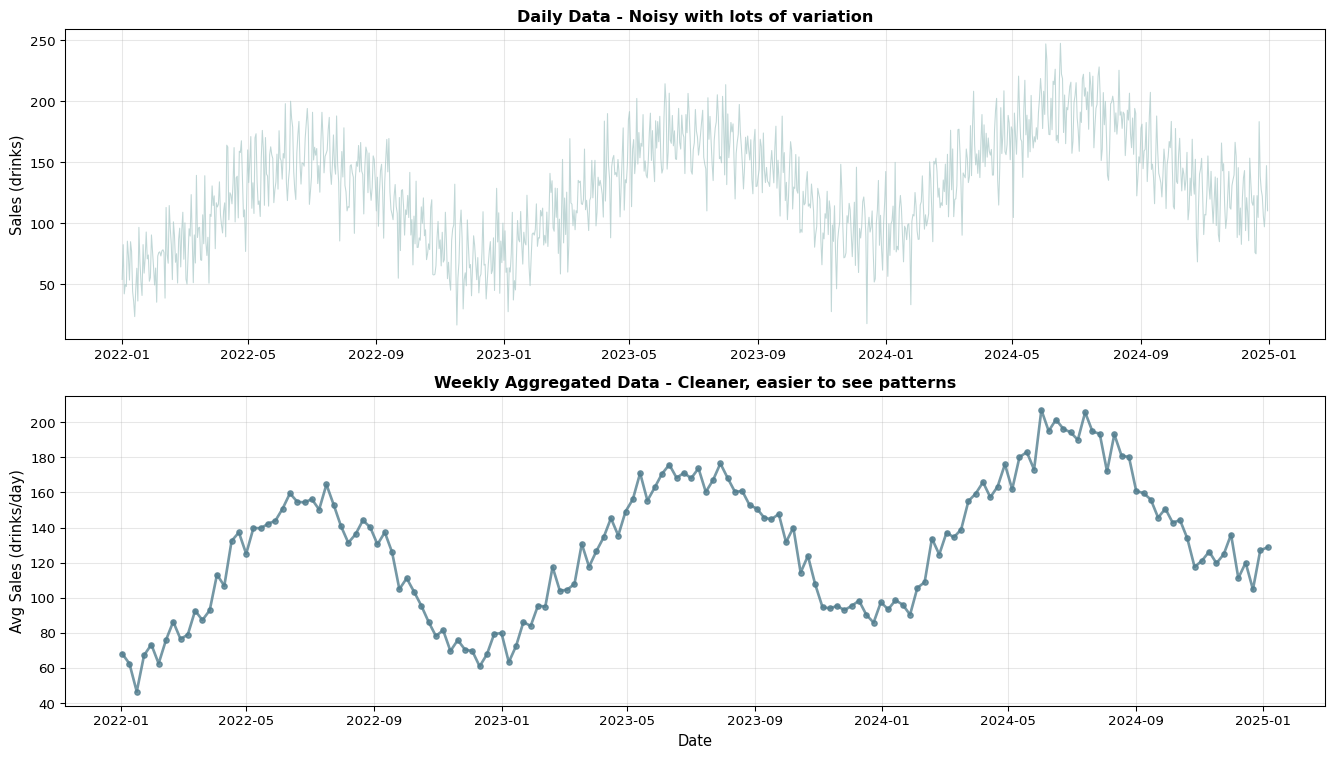

In [21]:
# Convert daily Bean Counter sales to weekly averages
weekly_sales = df.set_index('date').resample('W')['sales'].mean()
print(f"Daily data: {len(df)} observations")
print(f"Weekly data: {len(weekly_sales)} observations")
print(f"\nFirst 3 weeks:")
print(weekly_sales.head(3))

# Visualize the difference between daily and weekly data
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Top: Daily data (noisy)
axes[0].plot(df['date'], df['sales'], linewidth=0.8, alpha=0.7, color='#A7C7C6')
axes[0].set_ylabel('Sales (drinks)', fontsize=11)
axes[0].set_title('Daily Data - Noisy with lots of variation', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Bottom: Weekly data (smooth)
axes[1].plot(weekly_sales.index, weekly_sales.values, 'o-', linewidth=2, markersize=4,
             alpha=0.8, color='#537E8F')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Avg Sales (drinks/day)', fontsize=11)
axes[1].set_title('Weekly Aggregated Data - Cleaner, easier to see patterns', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

> **Tip**
>
> Aggregating to weekly data reduces noise and makes trends easier to
> see! Notice how the weekly plot makes the trend much clearer.

## Understanding Holt’s Method

**The Math (simplified):**

-   **Level:**
    $L_t = \alpha \times Y_t + (1-\alpha) \times (L_{t-1} + b_{t-1})$
-   **Trend:**
    $b_t = \beta \times (L_t - L_{t-1}) + (1-\beta) \times b_{t-1}$
-   **Forecast:** $\hat{Y}_{t+h} = L_t + h \times b_t$

**In plain English:**

-   Level smooths the current position
-   Trend smooths the growth rate
-   Forecast = Current level + (periods ahead × trend)

Let’s see Holt’s method in action using Python’s `statsmodels` library:

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create sample trending data
weeks = pd.date_range('2024-01-01', periods=20, freq='W')
trending_sales = 100 + 3*np.arange(20) + np.random.normal(0, 5, 20)
ts_trending = pd.Series(trending_sales, index=weeks)

# Fit Holt's model (trend, but no seasonality)
model_holt = ExponentialSmoothing(ts_trending, trend='add', seasonal=None)
fitted_holt = model_holt.fit(smoothing_level=0.3, smoothing_trend=0.2)

# Forecast next 4 periods
forecast_holt = fitted_holt.forecast(steps=4)

print("Last 3 actual values:")
print(ts_trending.tail(3))
print(f"\nNext 4 week forecast with Holt's method:")
print(forecast_holt)
print("\nNotice: Forecasts increase each week (captures trend!)")

Last 3 actual values:
2024-05-05    147.700470
2024-05-12    156.602208
2024-05-19    165.404895
Freq: W-SUN, dtype: float64

Next 4 week forecast with Holt's method:
2024-05-26    161.150728
2024-06-02    164.553567
2024-06-09    167.956406
2024-06-16    171.359244
Freq: W-SUN, dtype: float64

Notice: Forecasts increase each week (captures trend!)

## Exercise 4.1 - Apply Holt’s Method to Bean Counter

Bean Counter’s sales are growing. Use Holt’s method to capture this
trend.

In [23]:
# Prepare weekly data (aggregate daily to weekly to reduce noise)
df_weekly = df.set_index('date').resample('W')['sales'].mean()

# YOUR CODE BELOW
# Split: first 90 weeks for training, last 14 for testing
train_weekly =   # First 90 weeks
test_weekly =    # Last 14 weeks

# Fit Holt's model
model_holt =   # ExponentialSmoothing with trend='add', seasonal=None
fitted_holt =  # Fit the model
holt_forecast =  # Forecast 14 weeks

In [25]:
# Don't modify below
assert len(holt_forecast) == 14, "Should forecast 14 weeks"
assert holt_forecast.iloc[0] > holt_forecast.iloc[-1], "Holt's forecast should decrease (season!)"
print(f"Excellent! Holt's method applied successfully!")
print(f"Holt's captures negative trend: {holt_forecast.iloc[0]:.1f} → {holt_forecast.iloc[-1]:.1f}")

# Create comparison forecast with simple exponential smoothing
simple_forecast_weekly = exponential_smoothing_forecast(train_weekly, alpha=0.3, periods=14)

# Visualize comparison
plt.figure(figsize=(12, 8))

# Plot historical training data (last 30 weeks for context)
plt.plot(train_weekly.index[-90:], train_weekly.values[-90:], 'o-', color='#537E8F',
         linewidth=1.5, markersize=2, alpha=0.5, label='Historical (last 30 weeks)')

# Plot actual test data
plt.plot(test_weekly.index[:14], test_weekly.values[:14], 'o', color='black',
         markersize=2, alpha=0.9, label='Actual', zorder=5)

# Plot both forecasts
plt.plot(test_weekly.index[:14], simple_forecast_weekly, 's--', color='#A7C7C6',
         linewidth=2, markersize=3, label='Simple ES (flat)', alpha=0.8)
plt.plot(test_weekly.index[:14], holt_forecast, 'd-', color='#F6B265',
         linewidth=2.5, markersize=3, label="Holt's Method (with trend)")

plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Daily Sales', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Section 5 - Most Advanced: Holt-Winters Method

**The Challenge:** Bean Counter has BOTH trend (growing) AND seasonality
(summer peaks for iced coffee).

**Holt-Winters Solution:** Track THREE things:

1.  **Level** - Current baseline demand
2.  **Trend** - Growth rate
3.  **Seasonal Pattern** - Repeating cycle (e.g., summer highs)

## Understanding Holt-Winters

**When to use:**

-   Data has trend AND seasonality
-   You have ideally 2 full seasonal cycles (e.g., 2 years for yearly
    patterns)

Let’s demonstrate with monthly data:

In [26]:
# Create data with trend AND seasonality
months = pd.date_range('2022-01-01', periods=24, freq='M')
trend_comp = np.linspace(100, 150, 24)
seasonal_comp = 30 * np.sin(2 * np.pi * np.arange(24) / 12)
monthly_sales = trend_comp + seasonal_comp + np.random.normal(0, 5, 24)
ts_seasonal = pd.Series(monthly_sales, index=months)

# Fit Holt-Winters model
model_hw = ExponentialSmoothing(
    ts_seasonal,
    trend='add',           # Additive trend
    seasonal='add',        # Additive seasonality
    seasonal_periods=12    # 12 months = 1 year
)
fitted_hw = model_hw.fit()

# Forecast next 6 months
forecast_hw = fitted_hw.forecast(steps=6)

print("Last 3 months actual:")
print(ts_seasonal.tail(3))
print(f"\nNext 6 months forecast:")
print(forecast_hw)
print("\nNotice: Seasonal pattern continues (Jan is low, summer will be high)")

Last 3 months actual:
2023-10-31    121.824928
2023-11-30    121.818264
2023-12-31    134.481744
Freq: ME, dtype: float64

Next 6 months forecast:
2024-01-31    157.483905
2024-02-29    175.816373
2024-03-31    184.848236
2024-04-30    187.735748
2024-05-31    181.651676
2024-06-30    183.597933
Freq: ME, dtype: float64

Notice: Seasonal pattern continues (Jan is low, summer will be high)

/var/folders/_5/jkkjxxdd5f1955l380dky7n80000gn/T/ipykernel_96609/3645223708.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range('2022-01-01', periods=24, freq='M')

## Exercise 5.1 - Apply Holt-Winters

Now use Holt-Winters to capture both trend and seasonality in Bean
Counter’s weekly sales.

**Note:** For weekly data with yearly seasonality, we need 2+ years
(104+ weeks). We’ll use quarterly seasonality (13 weeks) since we have
104 weeks total.

In [27]:
# YOUR CODE BELOW
# Use the weekly data we created earlier
# Split: first 150 weeks training, last 8 weeks testing
train_hw = df_weekly.iloc[:150]
test_hw = df_weekly.iloc[150:158]  # Exactly 8 weeks for testing (all remaining data)

# Fit Holt-Winters with yearly seasonality (52 weeks = 1 year)
model_hw =   # ExponentialSmoothing with trend='add', seasonal='add', seasonal_periods=52
fitted_hw =  # Fit the model
hw_forecast =  # Forecast 8 weeks

# Compare all three methods on same test period
simple_forecast = exponential_smoothing_forecast(train_hw, alpha=0.3, periods=8)
holt_forecast_test = ExponentialSmoothing(train_hw, trend='add', seasonal=None).fit().forecast(8)

In [29]:
# Don't modify below
assert len(hw_forecast) == 8, "Should forecast 8 weeks"
# Holt-Winters should vary (seasonality), simple ES should be flat
hw_variation = hw_forecast.std()
simple_variation = np.std(simple_forecast)
assert hw_variation > simple_variation, "Holt-Winters should show more variation (seasonality)"
print(f"Fantastic! Holt-Winters applied successfully!")
print(f"Holt-Winters range: {hw_forecast.min():.1f} to {hw_forecast.max():.1f}")
print(f"Simple ES (flat): {simple_forecast[0]:.1f}")

# Section 6 - Measuring Forecast Accuracy

How good are our forecasts? Let’s measure and compare!

## Forecast Error Metrics

In [30]:
def calculate_mae(actual, forecast):
    """Mean Absolute Error - average size of errors"""
    errors = np.abs(actual - forecast)
    return np.mean(errors)

def calculate_rmse(actual, forecast):
    """Root Mean Squared Error - penalizes large errors more"""
    errors = (actual - forecast) ** 2
    return np.sqrt(np.mean(errors))

# Example
actual = np.array([100, 105, 98, 103])
forecast = np.array([102, 103, 100, 101])
print(f"MAE: {calculate_mae(actual, forecast):.1f} (average error)")
print(f"RMSE: {calculate_rmse(actual, forecast):.1f} (penalizes big errors)")

MAE: 2.0 (average error)
RMSE: 2.0 (penalizes big errors)

> **MAE vs RMSE**
>
> -   **MAE:** Average error size (easier to interpret, in same units as
>     data)
> -   **RMSE:** Penalizes large errors more heavily (sensitive to
>     outliers)
> -   **In business:** MAE often preferred for its simplicity and
>     interpretability

## Exercise 6.1 - Compare All Methods

Let’s have a forecasting comparison! Which method works best for Bean
Counter?

In [31]:
# YOUR CODE BELOW
# Calculate MAE for all methods on the test period (last 8 weeks)
test_actual = test_hw.values

# Convert forecasts to numpy arrays for comparison
simple_array = np.array(simple_forecast)
holt_array = holt_forecast_test.values
hw_array = hw_forecast.values

# Calculate MAE for each method
mae_simple =   # MAE for simple exponential smoothing
mae_holt =     # MAE for Holt's method
mae_hw =       # MAE for Holt-Winters

# Find the winner (lowest MAE)
mae_values = [mae_simple, mae_holt, mae_hw]
best_method_index = np.argmin(mae_values) # Index of best method

In [33]:
# Don't modify below
methods = ['Simple ES', "Holt's Method", 'Holt-Winters']
print("Forecast accuracy comparison complete!")
print(f"\nWinner: {methods[best_method_index]}")

# Visualize the comparison
plt.figure(figsize=(12, 8))

# Plot historical training data
plt.plot(train_hw.index[-30:], train_hw.values[-30:], 'o-', color='#537E8F',
         linewidth=1.5, markersize=3, alpha=0.5, label='Historical (last 30 weeks)')

# Plot actual test data
plt.plot(test_hw.index, test_hw.values, 'o', color='black',
         markersize=10, alpha=0.9, label='Actual (Test)', zorder=5)

# Plot all three forecasts
plt.plot(test_hw.index, simple_array, 's--', color='#A7C7C6',
         linewidth=2, markersize=3, label=f'Simple ES (MAE: {mae_simple:.1f})')
plt.plot(test_hw.index, holt_array, '^--', color='#F6B265',
         linewidth=2, markersize=3, label=f"Holt's (MAE: {mae_holt:.1f})")
plt.plot(test_hw.index, hw_array, 'd--', color='#DB6B6B',
         linewidth=2.5, markersize=3, label=f'Holt-Winters (MAE: {mae_hw:.1f})')

plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Daily Sales', fontsize=12)
plt.title('Method Comparison: Which Captures Trend + Seasonality Best?', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conclusion

**Outstanding work!** You’ve mastered time series forecasting for Bean
Counter! You’re now fully prepared for MegaMart’s Christmas Challenge!

> **Tips for Competition**
>
> **Before You Start:**
>
> 1.  **Plot first** - Visualize all three products
> 2.  **Check for patterns** - Trend? Seasonality? Both?
> 3.  **Note the lead times** - Affects which weeks you forecast
>
> **During Analysis:**
>
> 1.  **Start simple** - Moving average is a great baseline
> 2.  **Use Holt’s for trends** - If sales are growing/declining
> 3.  **Use Holt-Winters for seasonality** - If you see repeating
>     patterns
>
> **Validation:**
>
> 1.  **Backtest first** - Test your method on last 4 weeks before the
>     test period
> 2.  **Calculate MAE** - Measure accuracy objectively

**Good luck with the MegaMart Christmas Inventory Challenge!**